In [2]:
import numpy as np
import torch
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms,utils

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5],std=[0.5])])
train_data = datasets.MNIST(root = "G:/dataset/",
                            transform=transform,
                            train = True,
                            download = False)

test_data = datasets.MNIST(root="G:/dataset/",
                           transform = transform,
                           train = False)


print("train_data_len:"+str(len(train_data)))
print("test_data_len:"+str(len(test_data)))


train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,
                                          shuffle=True,num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=64,
                                          shuffle=True,num_workers=1)

print("train_loader_len:"+str(len(train_loader)))
print("test_loader_len:"+str(len(test_loader)))

train_data_len:60000
test_data_len:10000
train_loader_len:938
test_loader_len:157


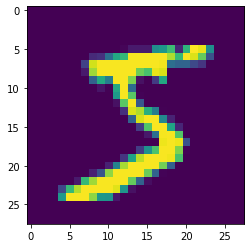

In [3]:
oneimg,label = train_data[0]
oneimg = oneimg.numpy().transpose(1,2,0)
std = [0.5]
mean = [0.5]
oneimg = oneimg * std + mean
oneimg.resize(28,28)
plt.imshow(oneimg)
plt.show()

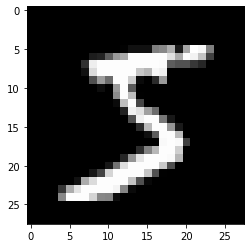

In [4]:

oneimg,label = train_data[0]
grid = utils.make_grid(oneimg)
grid = grid.numpy().transpose(1,2,0)
std = [0.5]
mean = [0.5]
grid = grid * std + mean
plt.imshow(grid)
plt.show()

<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?


tensor(9) tensor(1) tensor(8) tensor(6) tensor(3) tensor(9) tensor(1) tensor(6) 
tensor(0) tensor(0) tensor(8) tensor(1) tensor(9) tensor(2) tensor(5) tensor(2) 
tensor(1) tensor(0) tensor(8) tensor(7) tensor(8) tensor(8) tensor(9) tensor(6) 
tensor(7) tensor(8) tensor(0) tensor(5) tensor(7) tensor(3) tensor(3) tensor(1) 
tensor(5) tensor(7) tensor(4) tensor(3) tensor(5) tensor(7) tensor(2) tensor(4) 
tensor(1) tensor(2) tensor(8) tensor(4) tensor(6) tensor(8) tensor(2) tensor(7) 
tensor(6) tensor(0) tensor(1) tensor(5) tensor(7) tensor(8) tensor(6) tensor(9) 
tensor(1) tensor(0) tensor(8) tensor(5) tensor(5) tensor(2) tensor(0) tensor(1) 


<ipython-input-5-025868c8d772>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if i%8 is 0:


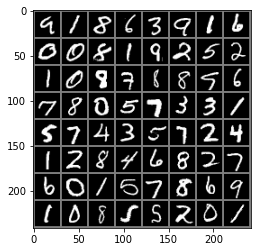

In [5]:
images, lables = next(iter(train_loader))
img = utils.make_grid(images)
# transpose 转置函数(x=0,y=1,z=2),新的x是原来的y轴大小，新的y是原来的z轴大小，新的z是原来的x大小
#相当于把x=1这个一道最后面去。
img = img.numpy().transpose(1,2,0) 
std = [0.5]
mean = [0.5]
img = img * std + mean
for i in range(64):
    print(lables[i], end=" ")
    i += 1
    if i%8 is 0:
        print(end='\n')
plt.imshow(img)
plt.show()

In [6]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        self.fc1 = nn.Linear(64*7*7,1024)#两个池化，所以是7*7而不是14*14
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,10)
#         self.dp = nn.Dropout(p=0.5)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 64 * 7* 7)#将数据平整为一维的 
        x = F.relu(self.fc1(x))
#         x = self.fc3(x)
#         self.dp(x)
        x = F.relu(self.fc2(x))   
        x = self.fc3(x)  
#         x = F.log_softmax(x,dim=1) NLLLoss()才需要，交叉熵不需要
        return x

net = CNN()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#也可以选择Adam优化方法
# optimizer = torch.optim.Adam(net.parameters(),lr=1e-2)

In [8]:
train_accs = []
train_loss = []
test_accs = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
for epoch in range(3):
    running_loss = 0.0
    for i,data in enumerate(train_loader,0):#0是下标起始位置默认为0
        # data 的格式[[inputs, labels]]       
#         inputs,labels = data
        inputs,labels = data[0].to(device), data[1].to(device)
        #初始为0，清除上个batch的梯度信息
        optimizer.zero_grad()         

        #前向+后向+优化     
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # loss 的输出，每个一百个batch输出，平均的loss
        running_loss += loss.item()
        if i%100 == 99:
            print('[%d,%5d] loss :%.3f' %
                 (epoch+1,i+1,running_loss/100))
            running_loss = 0.0
        train_loss.append(loss.item())

        # 训练曲线的绘制 一个batch中的准确率
        correct = 0
        total = 0
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)# labels 的长度
        correct = (predicted == labels).sum().item() # 预测正确的数目
        train_accs.append(100*correct/total)

print('Finished Training')

[1,  100] loss :2.290
[1,  200] loss :2.258
[1,  300] loss :2.187
[1,  400] loss :1.960
[1,  500] loss :1.284
[1,  600] loss :0.706
[1,  700] loss :0.488
[1,  800] loss :0.407
[1,  900] loss :0.376
[2,  100] loss :0.314
[2,  200] loss :0.280
[2,  300] loss :0.257
[2,  400] loss :0.255
[2,  500] loss :0.214
[2,  600] loss :0.239
[2,  700] loss :0.214
[2,  800] loss :0.200
[2,  900] loss :0.201
[3,  100] loss :0.169
[3,  200] loss :0.161
[3,  300] loss :0.158
[3,  400] loss :0.157
[3,  500] loss :0.125
[3,  600] loss :0.150
[3,  700] loss :0.131
[3,  800] loss :0.130
[3,  900] loss :0.124
Finished Training


In [9]:
PATH = './model_save/mnist_cnn_net.pth'
torch.save(net.state_dict(), PATH)

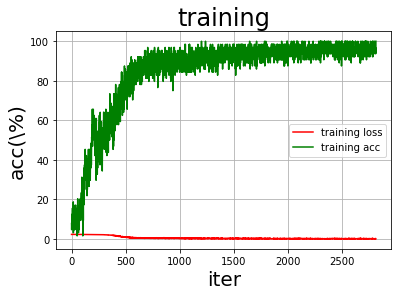

In [10]:
def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("acc(\%)", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()
train_iters = range(len(train_accs))
draw_train_process('training',train_iters,train_loss,train_accs,'training loss','training acc')

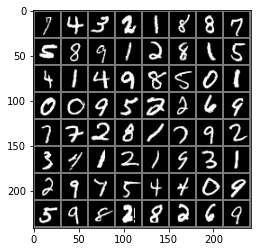

GroundTruth:  7 4 3 2 1 8 8 7 5 8 9 1 2 8 1 5 4 1 4 9 8 5 0 1 0 0 9 5 2 2 6 9 7 7 2 8 1 7 9 2 3 4 1 2 1 9 3 1 2 9 7 5 4 4 0 9 5 9 8 2 8 2 6 9


In [11]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
test_img = utils.make_grid(images)
test_img = test_img.numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean =  [0.5,0.5,0.5]
test_img = test_img*std+0.5
plt.imshow(test_img)
plt.show()
print('GroundTruth: ', ' '.join('%d' % labels[j] for j in range(64)))

In [12]:
test_net = CNN()
test_net.load_state_dict(torch.load(PATH))
test_out = test_net(images)

In [13]:
_, predicted = torch.max(test_out, dim=1)
print('Predicted: ', ' '.join('%d' % predicted[j] for j in range(64)))

Predicted:  7 4 3 2 1 8 8 7 5 8 9 1 2 8 1 5 4 1 4 9 8 5 0 1 0 0 9 5 2 2 6 9 7 7 2 8 1 7 9 2 3 4 1 2 1 9 3 1 2 9 7 5 4 4 0 9 5 9 8 2 8 2 6 9


In [14]:
correct = 0
total = 0
with torch.no_grad():# 进行评测的时候网络不更新梯度
    for data in test_loader:
        images, labels = data
        outputs = test_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)# labels 的长度
        correct += (predicted == labels).sum().item() # 预测正确的数目

print('Accuracy of the network on the  test images: %d %%' % (100 * correct / total))

Accuracy of the network on the  test images: 96 %


In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = test_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
#         print(predicted == labels)
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %d : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 98 %
Accuracy of 1 : 98 %
Accuracy of 2 : 96 %
Accuracy of 3 : 95 %
Accuracy of 4 : 99 %
Accuracy of 5 : 96 %
Accuracy of 6 : 95 %
Accuracy of 7 : 98 %
Accuracy of 8 : 94 %
Accuracy of 9 : 91 %
